<a href="https://colab.research.google.com/github/Charleyip/Charley/blob/main/%E2%80%9CBUSI2037_Group_Project_coding_ipynb_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the libraries**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
!pip install shap
import shap
import lightgbm as lgb
%matplotlib inline

from matplotlib import pyplot
from pprint import pprint
from IPython.display import display
from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, roc_auc_score, precision_score
from sklearn.model_selection import RandomizedSearchCV

plt.style.use("seaborn-colorblind")
sns.set_palette('pastel')
from collections import Counter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.4/572.4 kB 8.4 MB/s eta 0:00:00


The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bank_data = pd.read_csv('/content/drive/MyDrive/BUSI2037/BankChurners.csv')
bank_data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


# Data Preparation

In this step prepare the data for the analysis. Data might have null values or  be of different data types.

**Check for the data information**

In [ ]:
bank_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

From the above results we can see the data type of each column and ensure that there are no null values

In [ ]:
bank_data.rename(columns = {'CLIENTNUM': 'Customer_ID'}, inplace=True)

In [ ]:
bank_data['Dependent_count'] = pd.to_numeric(bank_data['Dependent_count'])

We proceed the data for further application.

**Boxplot for outlier treatment**
This is needed because sometimes the extreme outliers may affect the final Model.


In [ ]:
numeric_features = bank_data.select_dtypes(exclude=['object'])

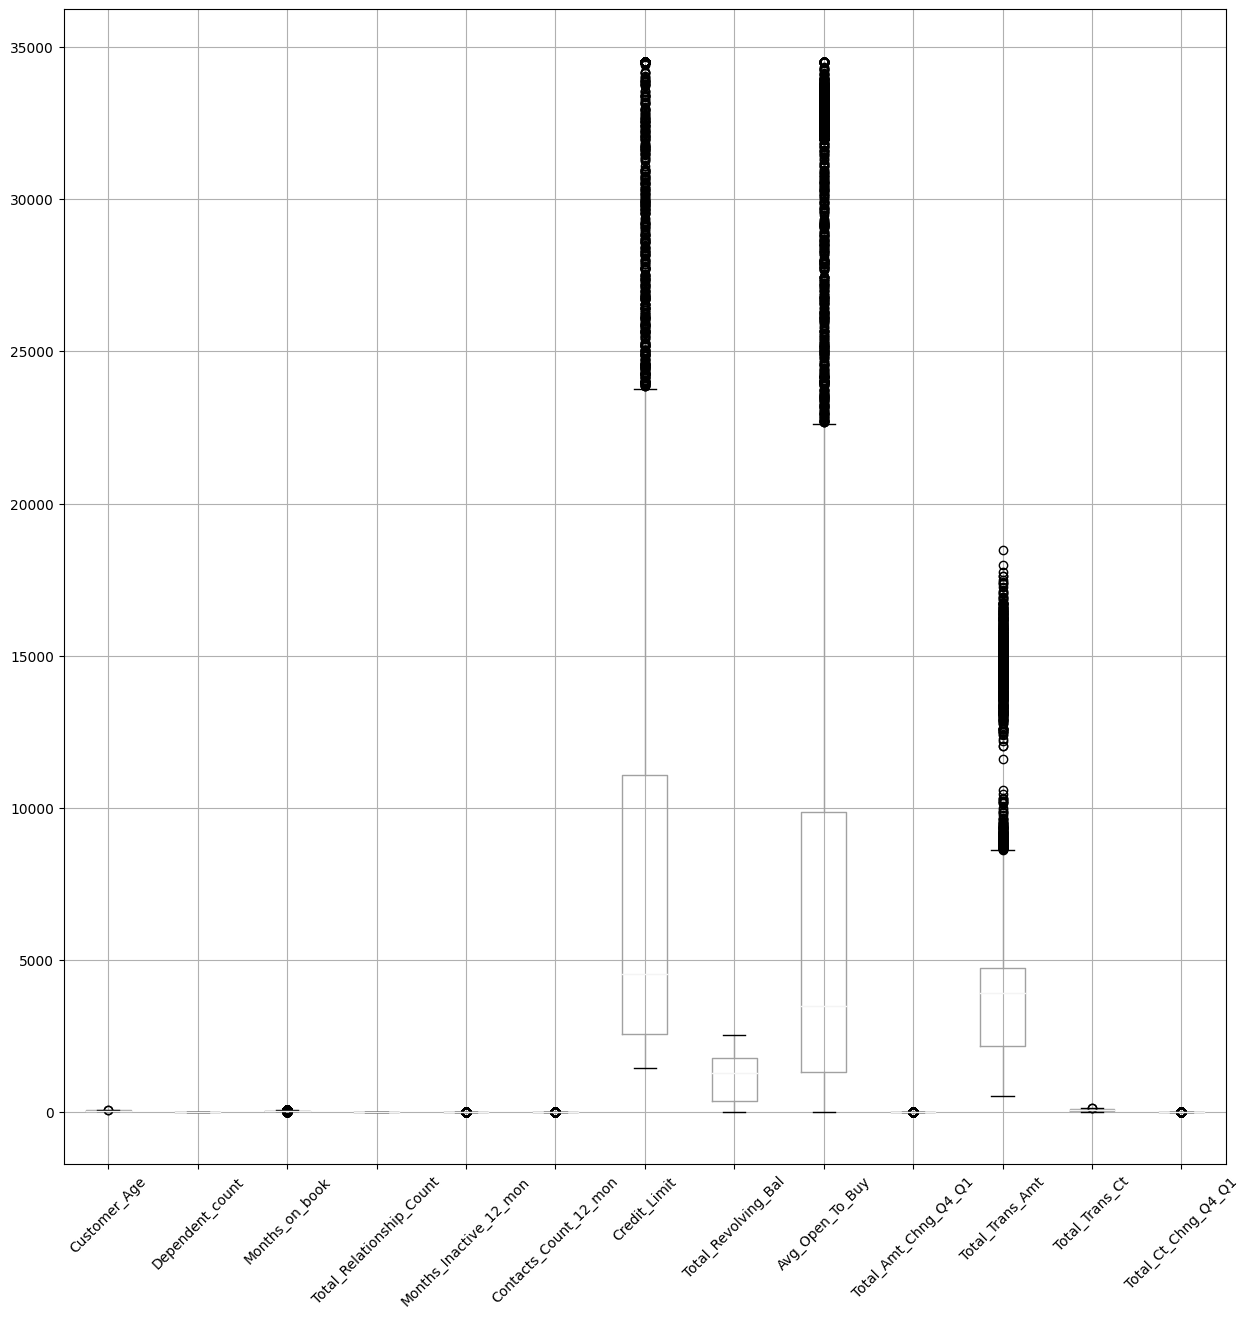

In [ ]:
plt.figure(figsize=(15,15))

bank_data.boxplot(column=['Customer_Age','Dependent_count','Months_on_book','Total_Relationship_Count','Months_Inactive_12_mon','Contacts_Count_12_mon','Credit_Limit',
                          'Total_Revolving_Bal','Avg_Open_To_Buy','Total_Amt_Chng_Q4_Q1','Total_Trans_Amt','Total_Trans_Ct','Total_Ct_Chng_Q4_Q1'])
plt.xticks(rotation=45)
plt.show()

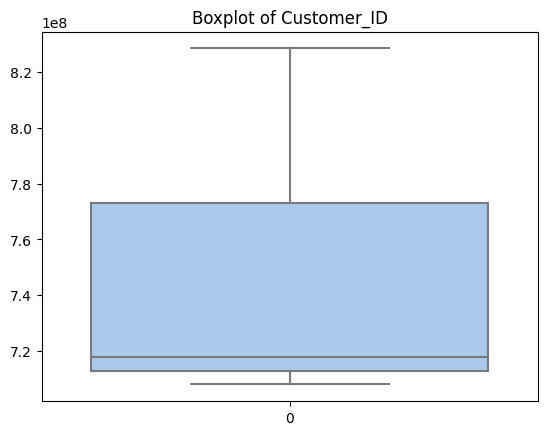

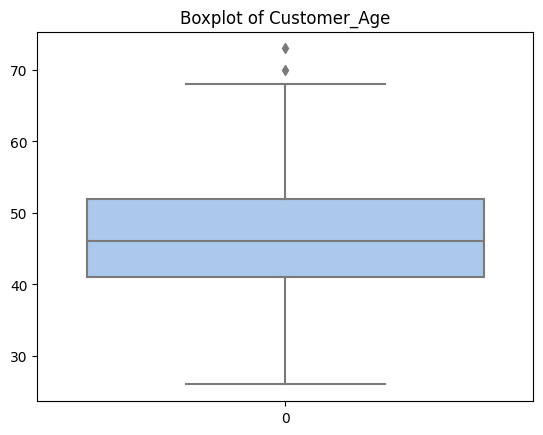

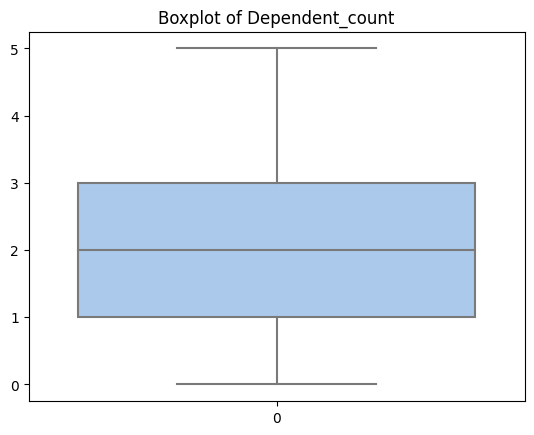

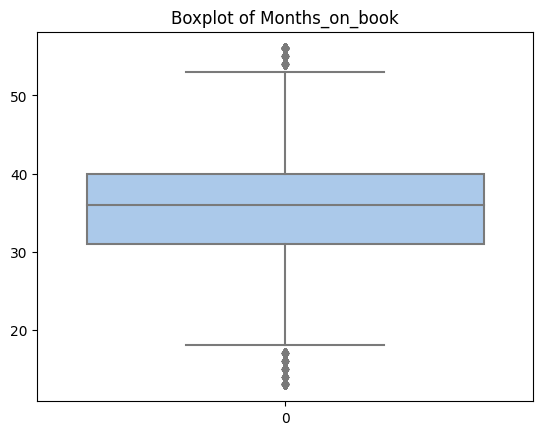

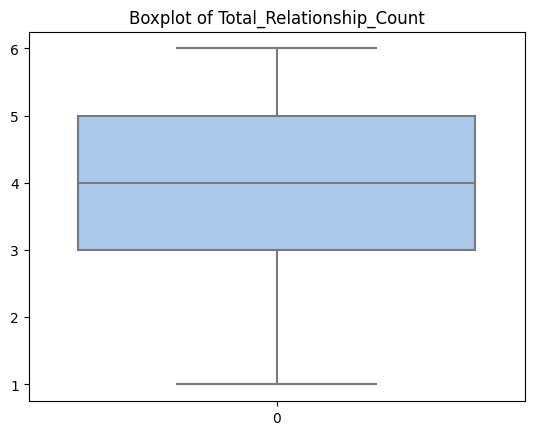

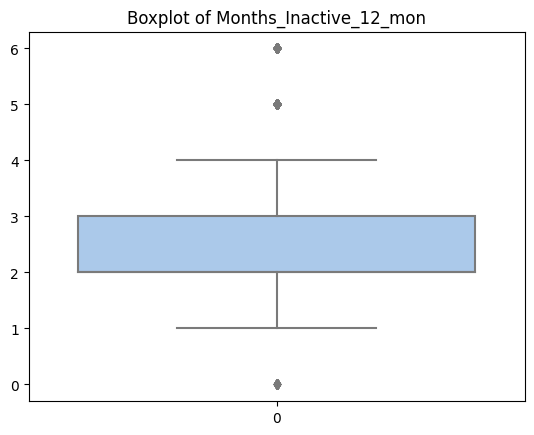

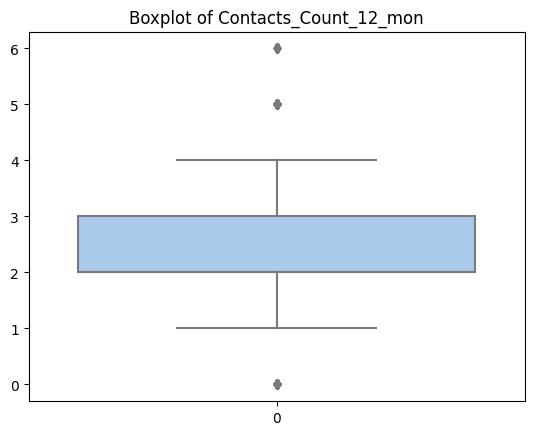

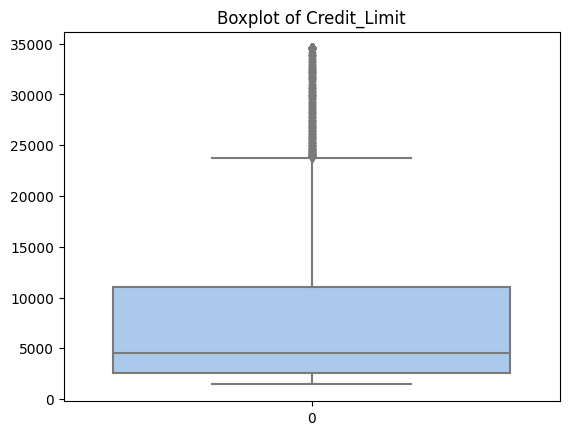

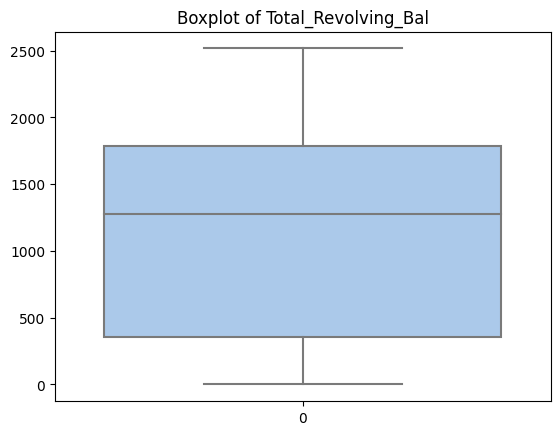

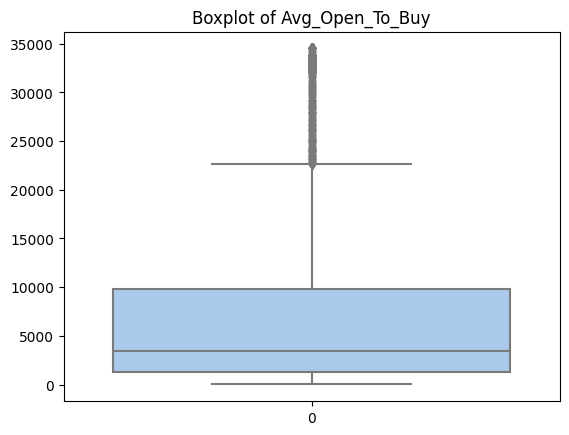

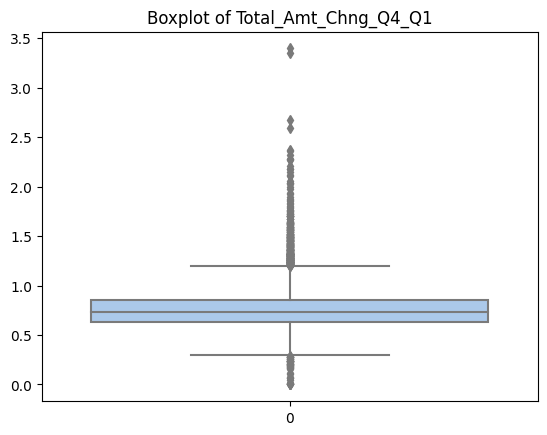

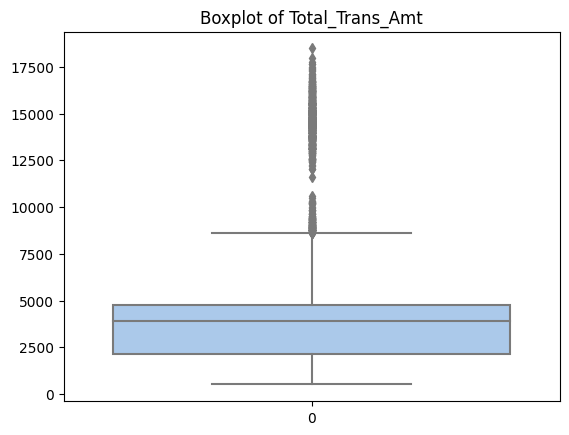

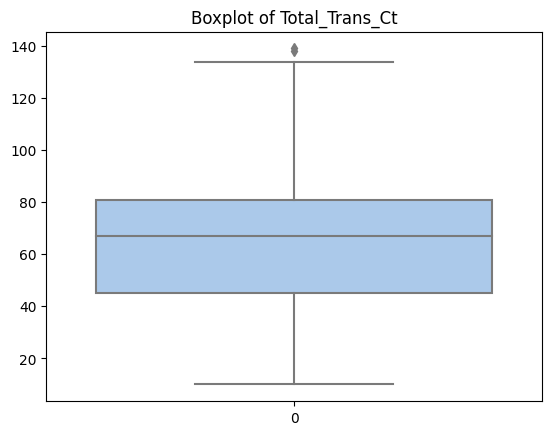

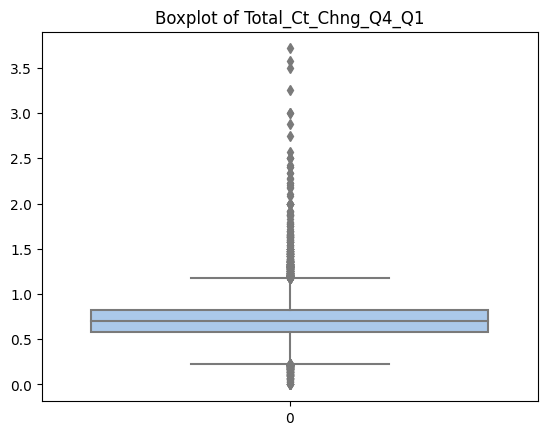

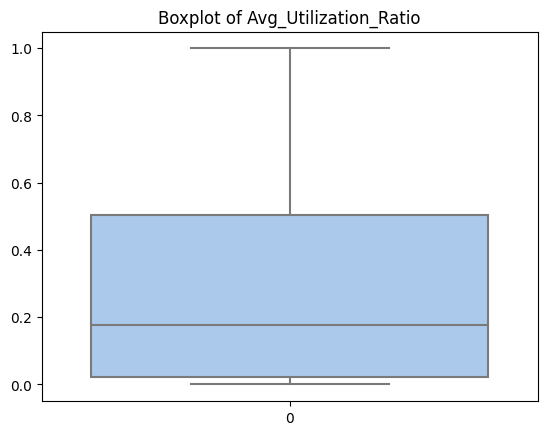

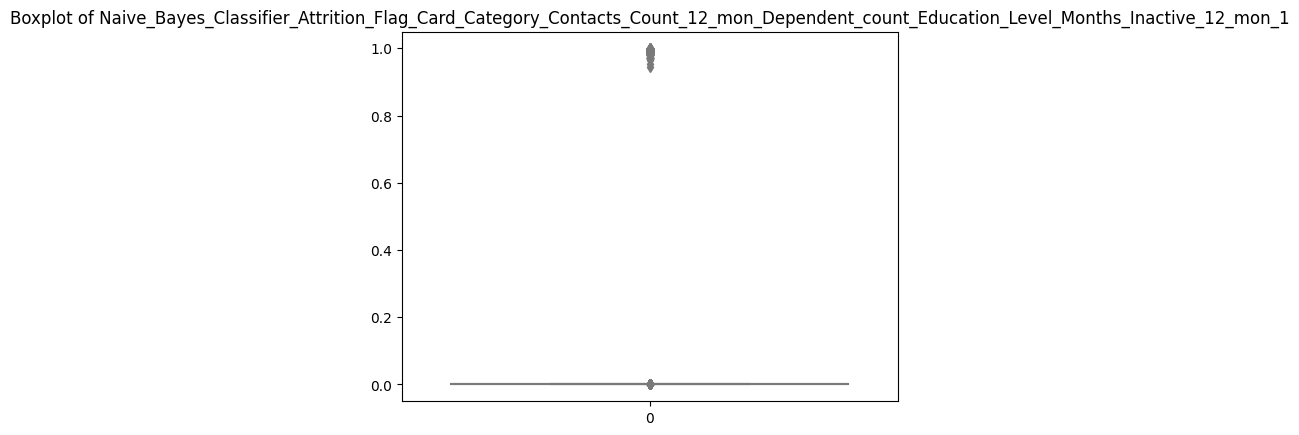

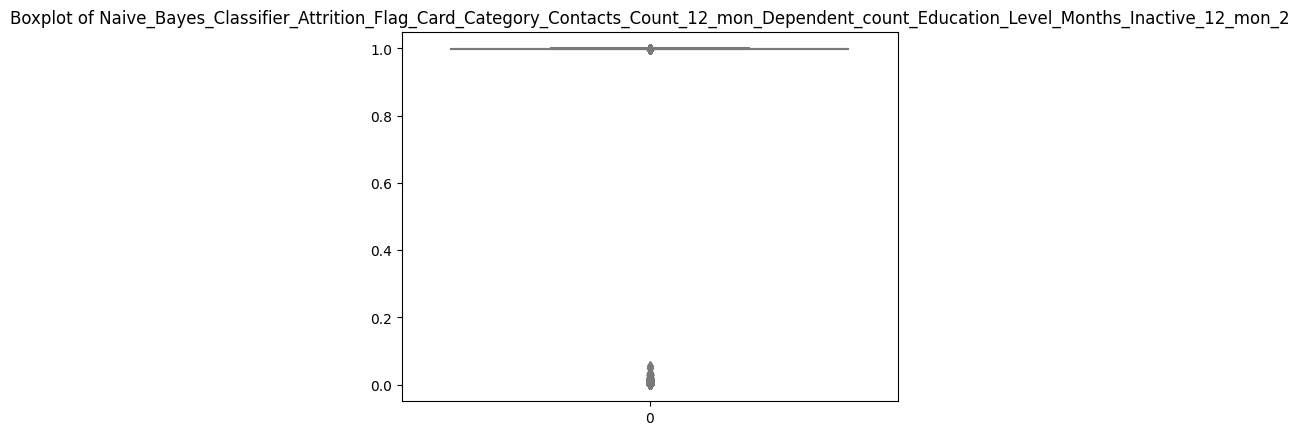

In [ ]:
for feature in numeric_features:
    sns.boxplot(bank_data[feature])
    plt.title('Boxplot of ' + str(feature))
    plt.show()

Not much weightage is given to EDA at this point.

In [ ]:
bank_data.head()

,Customer_ID,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,...,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,...,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,...,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,...,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,...,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,...,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [ ]:
bank_data.drop(columns=['Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
                'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2',
                'Customer_ID'],axis=1,inplace=True)
bank_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


# Exploratory Data Analysis (EDA)
First we do data visualizaiton


In [ ]:

def PlotMultiplePie(df,categorical_features = None,dropna = False):
    threshold = 30
    if categorical_features == None:
        categorical_features = df.select_dtypes(['object','category']).columns.to_list()
        print(categorical_features)
    for cat_feature in categorical_features:
        num_unique = df[cat_feature].nunique(dropna = dropna)
        num_missing = df[cat_feature].isna().sum()
        if num_unique <= threshold:
            print('Pie Chart for: ', cat_feature)
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            fig = px.pie(df[cat_feature].value_counts(dropna = dropna), values=cat_feature,
                 names = df[cat_feature].value_counts(dropna = dropna).index,title = cat_feature,template='ggplot2')
            fig.show()
        else:
            print('Pie Chart for ',cat_feature,' is unavailable due high number of Unique Values ')
            print('Number of Unique Values: ', num_unique)
            print('Number of Missing Values: ', num_missing)
            print('\n')

In [ ]:
PlotMultiplePie(bank_data)

['Attrition_Flag', 'Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category']
Pie Chart for:  Attrition_Flag
Number of Unique Values:  2
Number of Missing Values:  0


Pie Chart for:  Gender
Number of Unique Values:  2
Number of Missing Values:  0


Pie Chart for:  Education_Level
Number of Unique Values:  7
Number of Missing Values:  0


Pie Chart for:  Marital_Status
Number of Unique Values:  4
Number of Missing Values:  0


Pie Chart for:  Income_Category
Number of Unique Values:  6
Number of Missing Values:  0


Pie Chart for:  Card_Category
Number of Unique Values:  4
Number of Missing Values:  0


<ipython-input-14-05b49c93a9b5>:16: MatplotlibDeprecationWarning:

Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.



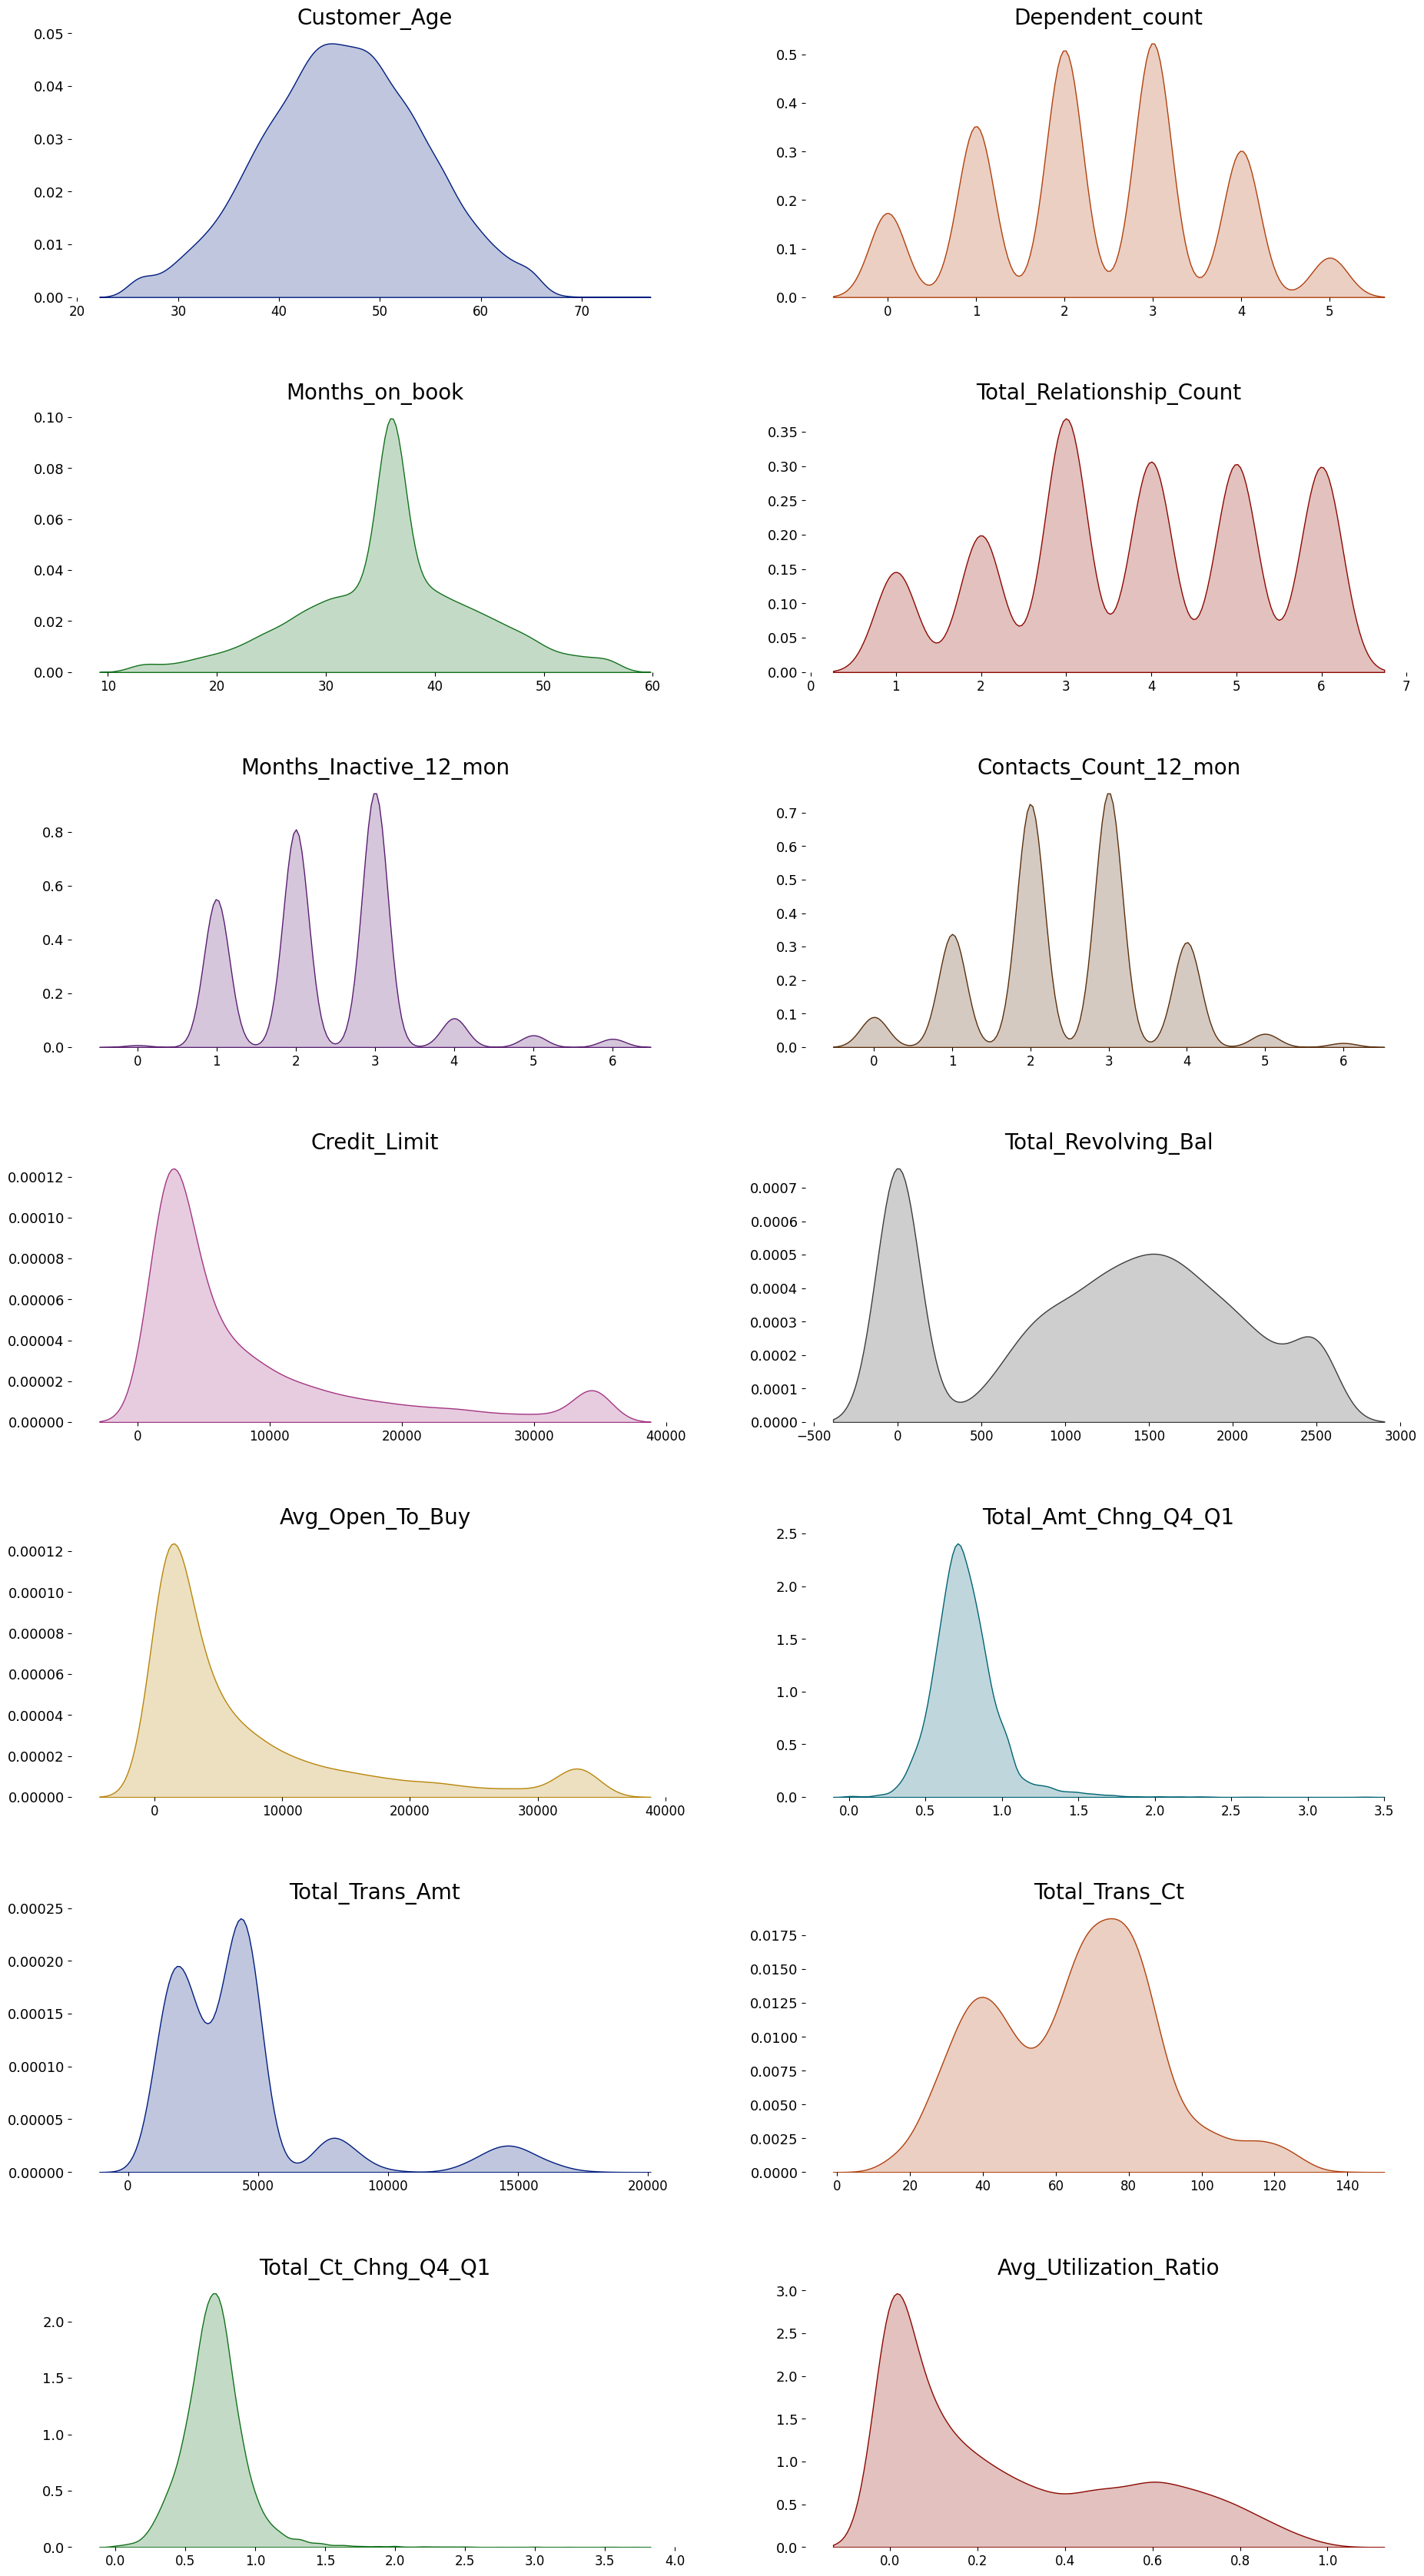

In [ ]:
def plot_design():
    plt.xlabel('')
    plt.ylabel('')
    plt.yticks(fontsize=13, color='black')
    plt.box(False)
    plt.title(i[1], fontsize=20, color='black')
    plt.tight_layout(pad=5.0)
    plt.grid(axis='x')
numeric = bank_data.select_dtypes(exclude=object).columns
fig, ax = plt.subplots(figsize =(20, 35))
fig.patch.set_facecolor('white')
plt.rcParams['font.family'] = 'Hiragino Kaku Gothic Pro'
plt.rcParams['font.size'] = 12
colors = sns.color_palette("dark", n_colors=14).as_hex()
for i in (enumerate(numeric)):
    plt.subplot(7, 2, i[0]+1)
    sns.kdeplot(x = i[1], data = bank_data, color=colors[i[0]], fill=True)
    plt.grid(axis='x')
    plot_design()

We can see that the customer age is almost normally distributed. And there are positvekly skewed and negatively skewed distributions as well.


In [ ]:
skew_limit = 0.5
skew_vals = bank_data[numeric].skew()

skew_cols = (skew_vals
             .sort_values(ascending=False)
             .to_frame()
             .rename(columns={0:'Skewness'})
             .query('abs(Skewness) > {0}'.format(skew_limit)))

skew_cols

,Skewness
Total_Ct_Chng_Q4_Q1,2.064031
Total_Trans_Amt,2.041003
Total_Amt_Chng_Q4_Q1,1.732063
Credit_Limit,1.666726
Avg_Open_To_Buy,1.661697
Avg_Utilization_Ratio,0.718008
Months_Inactive_12_mon,0.633061


We can briefly shen light on the correlation betweem different variables.

<ipython-input-16-1cc23bc15fa4>:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



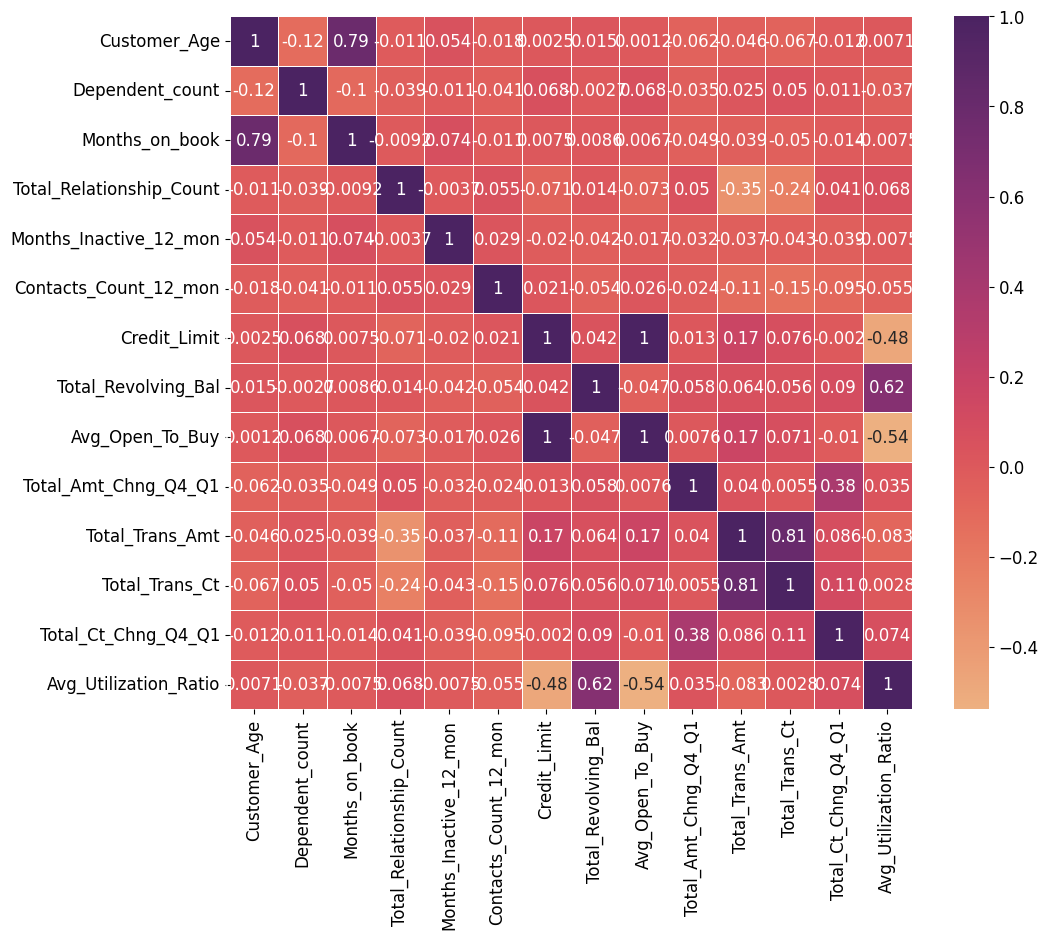

In [ ]:
corrData = bank_data.corr()
f, ax= plt.subplots(figsize = (11,9))
ax = sns.heatmap(corrData, cmap="flare", linewidths=.5,annot = True)
plt.show()

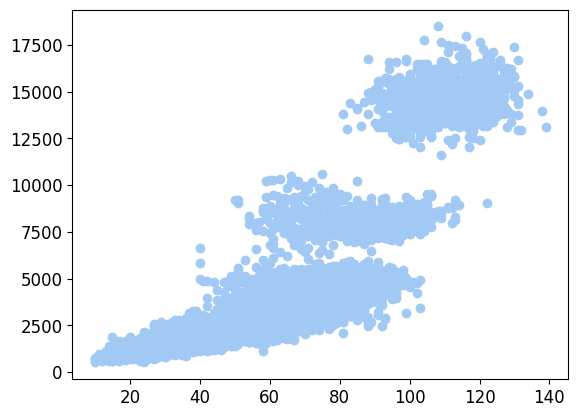

In [ ]:
plt.scatter(x=bank_data['Total_Trans_Ct'],y=bank_data['Total_Trans_Amt'])

# Linear Regression Model.
This model is used to predict that amount spent by any given customer in 12 months.

In [ ]:
bank_data.head()

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [ ]:
bank_data.Attrition_Flag.unique()

array(['Existing Customer', 'Attrited Customer'], dtype=object)

In [ ]:
bank_data.drop(columns=['Attrition_Flag'],axis=1,inplace=True)

**Gender**

Lets Convert Gender to Numberic Variable.
    

In [ ]:
bank_data['Gender'] = bank_data['Gender'].apply(lambda x: 1 if x=='M' else 0)
bank_data.head()

,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,45,1,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,49,0,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,51,1,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,40,0,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,40,1,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


## Hypothesis testing

In [ ]:
bank1 = bank_data[['Gender','Total_Trans_Amt']]

In [ ]:
bank_male = bank1.loc[bank1['Gender'] == 1]
bank_female = bank1.loc[bank1['Gender'] == 0]
display(bank_male['Total_Trans_Amt'].describe(),bank_female['Total_Trans_Amt'].describe())

count     4769.000000
mean      4493.706228
std       3835.315345
min        530.000000
25%       1881.000000
50%       3513.000000
75%       4711.000000
max      18484.000000
Name: Total_Trans_Amt, dtype: float64

count     5358.000000
mean      4324.318216
std       2951.002887
min        510.000000
25%       2424.250000
50%       4134.000000
75%       4751.750000
max      17437.000000
Name: Total_Trans_Amt, dtype: float64

In [ ]:
import pandas as pd
from scipy.stats import ttest_ind


In [ ]:
t_stat, p_value = ttest_ind(bank_male, bank_female, equal_var=False)[1]

# Print the results
print('t-statistic: ', t_stat)
print('p-value: ', p_value)
if p_value < 0.05:
    print('There is a significant difference in the total transaction amount between males and females.')
else:
    print('There is no significant difference in the total transaction amount between males and females.')

t-statistic:  0.0
p-value:  0.013597247371773494
There is a significant difference in the total transaction amount between males and females.


<ipython-input-25-dde6db063f94>:1: RuntimeWarning:

Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.



In [ ]:
def convert_cat_variables(col,prefix,df):
    dummies = pd.get_dummies(df[col],prefix=prefix)
    df = df.join(dummies)
    df.drop(col,axis=1,inplace=True)
    return df

In [ ]:
bank_data = convert_cat_variables('Education_Level','Education_Level',bank_data)
bank_data.head()

,Customer_Age,Gender,Dependent_count,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Education_Level_Unknown
0,45,1,3,Married,$60K - $80K,Blue,39,5,1,3,...,42,1.625,0.061,0,0,0,1,0,0,0
1,49,0,5,Single,Less than $40K,Blue,44,6,1,2,...,33,3.714,0.105,0,0,1,0,0,0,0
2,51,1,3,Married,$80K - $120K,Blue,36,4,1,0,...,20,2.333,0.000,0,0,1,0,0,0,0
3,40,0,4,Unknown,Less than $40K,Blue,34,3,4,1,...,20,2.333,0.760,0,0,0,1,0,0,0
4,40,1,3,Married,$60K - $80K,Blue,21,5,1,0,...,28,2.500,0.000,0,0,0,0,0,1,0


In [ ]:
bank_data.drop('Education_Level_Unknown',axis=1,inplace=True)
bank_data.head()

,Customer_Age,Gender,Dependent_count,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,...,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated
0,45,1,3,Married,$60K - $80K,Blue,39,5,1,3,...,1144,42,1.625,0.061,0,0,0,1,0,0
1,49,0,5,Single,Less than $40K,Blue,44,6,1,2,...,1291,33,3.714,0.105,0,0,1,0,0,0
2,51,1,3,Married,$80K - $120K,Blue,36,4,1,0,...,1887,20,2.333,0.000,0,0,1,0,0,0
3,40,0,4,Unknown,Less than $40K,Blue,34,3,4,1,...,1171,20,2.333,0.760,0,0,0,1,0,0
4,40,1,3,Married,$60K - $80K,Blue,21,5,1,0,...,816,28,2.500,0.000,0,0,0,0,0,1


In [ ]:
bank_data = convert_cat_variables('Marital_Status','Marital_Status',bank_data)
bank_data.head()

,Customer_Age,Gender,Dependent_count,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single,Marital_Status_Unknown
0,45,1,3,$60K - $80K,Blue,39,5,1,3,12691.0,...,0,0,0,1,0,0,0,1,0,0
1,49,0,5,Less than $40K,Blue,44,6,1,2,8256.0,...,0,0,1,0,0,0,0,0,1,0
2,51,1,3,$80K - $120K,Blue,36,4,1,0,3418.0,...,0,0,1,0,0,0,0,1,0,0
3,40,0,4,Less than $40K,Blue,34,3,4,1,3313.0,...,0,0,0,1,0,0,0,0,0,1
4,40,1,3,$60K - $80K,Blue,21,5,1,0,4716.0,...,0,0,0,0,0,1,0,1,0,0


In [ ]:
bank_data.drop('Marital_Status_Unknown',axis=1,inplace=True)
bank_data.head()

,Customer_Age,Gender,Dependent_count,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,45,1,3,$60K - $80K,Blue,39,5,1,3,12691.0,...,0.061,0,0,0,1,0,0,0,1,0
1,49,0,5,Less than $40K,Blue,44,6,1,2,8256.0,...,0.105,0,0,1,0,0,0,0,0,1
2,51,1,3,$80K - $120K,Blue,36,4,1,0,3418.0,...,0.000,0,0,1,0,0,0,0,1,0
3,40,0,4,Less than $40K,Blue,34,3,4,1,3313.0,...,0.760,0,0,0,1,0,0,0,0,0
4,40,1,3,$60K - $80K,Blue,21,5,1,0,4716.0,...,0.000,0,0,0,0,0,1,0,1,0


In [ ]:
bank_data.Card_Category.unique()

array(['Blue', 'Gold', 'Silver', 'Platinum'], dtype=object)

In [ ]:
def transformCategory(x):
    #print(x)
    if x=='Blue': return 0
    elif x=='Gold': return 2
    elif x=='Silver': return 1
    elif x=='Platinum': return 3

In [ ]:
bank_data['Card_Category'].value_counts()

Blue        9436
Silver       555
Gold         116
Platinum      20
Name: Card_Category, dtype: int64

In [ ]:
bank_data['Card_Category'] = bank_data['Card_Category'].apply(transformCategory)
bank_data.head()

,Customer_Age,Gender,Dependent_count,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,45,1,3,$60K - $80K,0,39,5,1,3,12691.0,...,0.061,0,0,0,1,0,0,0,1,0
1,49,0,5,Less than $40K,0,44,6,1,2,8256.0,...,0.105,0,0,1,0,0,0,0,0,1
2,51,1,3,$80K - $120K,0,36,4,1,0,3418.0,...,0.000,0,0,1,0,0,0,0,1,0
3,40,0,4,Less than $40K,0,34,3,4,1,3313.0,...,0.760,0,0,0,1,0,0,0,0,0
4,40,1,3,$60K - $80K,0,21,5,1,0,4716.0,...,0.000,0,0,0,0,0,1,0,1,0


## ANOVA


In [ ]:
bank_data.Income_Category.unique()

array(['$60K - $80K', 'Less than $40K', '$80K - $120K', '$40K - $60K',
       '$120K +', 'Unknown'], dtype=object)

In [ ]:
bank_data.Income_Category.value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income_Category, dtype: int64

In [ ]:
def transformIncomeCat(x):
    if x=='Less than $40K': return 0
    elif x=='$40K - $60K': return 1
    elif x=='$60K - $80K': return 2
    elif x=='$80K - $120K': return 3
    elif x=='$120K +': return 4
    elif x=='Unknown': return 5

In [ ]:
bank_data.head()

,Customer_Age,Gender,Dependent_count,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,45,1,3,$60K - $80K,0,39,5,1,3,12691.0,...,0.061,0,0,0,1,0,0,0,1,0
1,49,0,5,Less than $40K,0,44,6,1,2,8256.0,...,0.105,0,0,1,0,0,0,0,0,1
2,51,1,3,$80K - $120K,0,36,4,1,0,3418.0,...,0.000,0,0,1,0,0,0,0,1,0
3,40,0,4,Less than $40K,0,34,3,4,1,3313.0,...,0.760,0,0,0,1,0,0,0,0,0
4,40,1,3,$60K - $80K,0,21,5,1,0,4716.0,...,0.000,0,0,0,0,0,1,0,1,0


In [ ]:
bank_data['Income_Category'] = bank_data['Income_Category'].apply(transformIncomeCat)
bank_data.head()

,Customer_Age,Gender,Dependent_count,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,...,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,45,1,3,2,0,39,5,1,3,12691.0,...,0.061,0,0,0,1,0,0,0,1,0
1,49,0,5,0,0,44,6,1,2,8256.0,...,0.105,0,0,1,0,0,0,0,0,1
2,51,1,3,3,0,36,4,1,0,3418.0,...,0.000,0,0,1,0,0,0,0,1,0
3,40,0,4,0,0,34,3,4,1,3313.0,...,0.760,0,0,0,1,0,0,0,0,0
4,40,1,3,2,0,21,5,1,0,4716.0,...,0.000,0,0,0,0,0,1,0,1,0


In [ ]:
bank_data['Income_Category']

0        2
1        0
2        3
3        0
4        2
        ..
10122    1
10123    1
10124    0
10125    1
10126    0
Name: Income_Category, Length: 10127, dtype: int64

In [ ]:
bank2 = bank_data[['Income_Category','Total_Trans_Amt']]
bank2

,Income_Category,Total_Trans_Amt
0,2,1144
1,0,1291
2,3,1887
3,0,1171
4,2,816
...,...,...
10122,1,15476
10123,1,8764
10124,0,10291
10125,1,8395


In [ ]:
bank2_income0 = bank2.loc[bank2['Income_Category'] == 0]
bank2_income1 = bank2.loc[bank2['Income_Category'] == 1]
bank2_income2 = bank2.loc[bank2['Income_Category'] == 2]
bank2_income3 = bank2.loc[bank2['Income_Category'] == 3]
display(bank2_income0['Total_Trans_Amt'].describe(),bank2_income1['Total_Trans_Amt'].describe(),bank2_income2['Total_Trans_Amt'].describe(),bank2_income3['Total_Trans_Amt'].describe())

count     3561.000000
mean      4363.420107
std       3097.398449
min        510.000000
25%       2398.000000
50%       4099.000000
75%       4751.000000
max      17628.000000
Name: Total_Trans_Amt, dtype: float64

count     1790.000000
mean      4405.618994
std       3382.499980
min        569.000000
25%       2141.000000
50%       3967.000000
75%       4741.750000
max      17744.000000
Name: Total_Trans_Amt, dtype: float64

count     1402.000000
mean      4450.712553
std       3789.005119
min        530.000000
25%       1903.250000
50%       3552.500000
75%       4672.250000
max      18484.000000
Name: Total_Trans_Amt, dtype: float64

count     1535.000000
mean      4482.960261
std       3788.213644
min        563.000000
25%       1836.500000
50%       3525.000000
75%       4741.500000
max      17498.000000
Name: Total_Trans_Amt, dtype: float64

In [ ]:
bank2 = bank2.drop(bank2[bank2['Income_Category'] == 5].index)

In [ ]:
bank2.Income_Category.value_counts()

0    3561
1    1790
3    1535
2    1402
4     727
Name: Income_Category, dtype: int64

In [ ]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Fit the ANOVA model
model = ols('Total_Trans_Amt ~ C(Income_Category)', data=bank2).fit()

# Print the ANOVA table
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                          sum_sq      df         F    PR(>F)
C(Income_Category)  2.788193e+07     4.0  0.585192  0.673365
Residual            1.073222e+11  9010.0       NaN       NaN


In [ ]:
f_statistic = anova_table['F']['Income_Category']
p_value = anova_table['PR(>F)']['Income_Category']

# Print the results
print(f"F-statistic: {f_statistic}")
print(f"P-value: {p_value}")


KeyError: ignored

In [ ]:
if p_value < 0.05:
    print(' there is enough evidence to conclude that the means of the treatment groups are significantly different')
else:
    print(' there is not enough evidence to conclude that the means of the treatment groups are significantly different')

In [ ]:
from sklearn.model_selection import train_test_split

## Calculate VIF to eliminate Multicolinearity

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def cal_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif.sort_values('VIF',ascending=False)

In [ ]:
X = bank_data.drop('Total_Trans_Amt',axis=1)
cal_vif(X)

/usr/local/lib/python3.9/dist-packages/statsmodels/stats/outliers_influence.py:195: RuntimeWarning:

divide by zero encountered in double_scalars



,variables,VIF
11,Avg_Open_To_Buy,inf
10,Total_Revolving_Bal,inf
9,Credit_Limit,inf
0,Customer_Age,78.007816
5,Months_on_book,56.451558
12,Total_Amt_Chng_Q4_Q1,14.288867
14,Total_Ct_Chng_Q4_Q1,11.840807
13,Total_Trans_Ct,8.511693
6,Total_Relationship_Count,6.942885
23,Marital_Status_Married,6.598098


**Lets eliminate all the columns with VIF > 10**

To eliminate the multicollinearity

In [ ]:
bank_data.drop(columns=['Avg_Open_To_Buy','Total_Revolving_Bal','Credit_Limit','Customer_Age','Months_on_book','Total_Amt_Chng_Q4_Q1','Total_Ct_Chng_Q4_Q1'],axis=1,inplace=True)
bank_data.head()

,Gender,Dependent_count,Income_Category,Card_Category,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Total_Trans_Amt,Total_Trans_Ct,Avg_Utilization_Ratio,Education_Level_College,Education_Level_Doctorate,Education_Level_Graduate,Education_Level_High School,Education_Level_Post-Graduate,Education_Level_Uneducated,Marital_Status_Divorced,Marital_Status_Married,Marital_Status_Single
0,1,3,2,0,5,1,3,1144,42,0.061,0,0,0,1,0,0,0,1,0
1,0,5,0,0,6,1,2,1291,33,0.105,0,0,1,0,0,0,0,0,1
2,1,3,3,0,4,1,0,1887,20,0.000,0,0,1,0,0,0,0,1,0
3,0,4,0,0,3,4,1,1171,20,0.760,0,0,0,1,0,0,0,0,0
4,1,3,2,0,5,1,0,816,28,0.000,0,0,0,0,0,1,0,1,0


In [ ]:
X = bank_data.drop('Total_Trans_Amt',axis=1)
cal_vif(X)

,variables,VIF
7,Total_Trans_Ct,7.135825
4,Total_Relationship_Count,6.235320
5,Months_Inactive_12_mon,5.738375
16,Marital_Status_Married,5.663763
6,Contacts_Count_12_mon,5.378584
17,Marital_Status_Single,5.024549
1,Dependent_count,4.004541
11,Education_Level_Graduate,2.840589
2,Income_Category,2.403291
8,Avg_Utilization_Ratio,2.257832


## Build Linear Regression Model

Here we chiefly use the OLS regression model to estimate the parameter of the linear regression.

In [ ]:
import statsmodels.api as sm
def doLinearRegression(data,predictColName):
    result = dict()
    x_train,x_test,y_train,y_test = train_test_split(data.drop(predictColName,axis=1),data[predictColName],test_size=0.3,random_state=112)
    x_train = sm.add_constant(x_train)
    x_test = sm.add_constant(x_test)
    model = sm.OLS(y_train,x_train)
    model_result = model.fit()
    result['model_result'] = model_result
    result['x_train'] = x_train
    result['x_test'] = x_test
    result['y_train'] = y_train
    result['y_test'] = y_test
    return result

In [ ]:
result1 = doLinearRegression(bank_data,'Total_Trans_Amt')
result1['model_result'].summary()

NameError: ignored


Now By keeping threshold of 5%, lets eliminate all the features which have P-value > 0.5

In [ ]:
bank_data.drop('Contacts_Count_12_mon',axis=1,inplace=True)

In [ ]:
result1 = doLinearRegression(bank_data,'Total_Trans_Amt')
result1['model_result'].summary()

NameError: ignored

In [ ]:
bank_data.drop('Months_Inactive_12_mon',axis=1,inplace=True)
result1 = doLinearRegression(bank_data,'Total_Trans_Amt')
result1['model_result'].summary()

In [ ]:
bank_data.drop(columns=['Education_Level_College','Education_Level_Doctorate','Education_Level_Graduate','Education_Level_High School',
                       'Education_Level_Post-Graduate','Education_Level_Uneducated'],axis=1,inplace=True)
result1 = doLinearRegression(bank_data,'Total_Trans_Amt')
result1['model_result'].summary()

In [ ]:
bank_data.drop(columns=['Marital_Status_Divorced','Marital_Status_Married'],axis=1,inplace=True)
result1 = doLinearRegression(bank_data,'Total_Trans_Amt')
result1['model_result'].summary()

**Notice that R2 and Adjusted R2 do not change even after eliminating all the unaffected features.**

It is indicated that there are strong multicollinearity and these features is dependent, so we should find the importance of them.  

In [ ]:
coef = result1['model_result'].params

In [ ]:
coef[1:].plot(kind='bar')